# Description
This notebook compares the results of training a Conditional Normalizing Flow model on the synthetic two moons data. The data have rotation and moon class as conditioning variables.

The comparison is between a base flow with no regularization at all and adding in Clipped Adam and Batchnormalization.

Lots of different hyperparamters are tested to see if we can get batch normalization to work

# Base loads

In [1]:
!pip install pyro-ppl==1.3.0

     |████████████████████████████████| 501kB 8.8MB/s 


In [2]:
!nvidia-smi

Sun Jun 14 21:16:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Mount my drive
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
plot_folder = f'{root_path}/plot_notebooks/generated_plots'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Git code

In [5]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples, simple_data_split_conditional, simple_data_split, circle_transform
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule


# Func def

In [0]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def rescale_samples(plot_flow_dist, scaler, n_samples=256):
    x_s = plot_flow_dist.sample((n_samples,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    if scaler is not None:
        x_s = scaler.inverse_transform(x_s)
    return x_s

def add_marker_w_prob(coords, obs_scaler, flow_dist, hub_map, name):
    scaled_coords = obs_scaler.transform(np.flip(np.array([coords])))
    log_prob = flow_dist.log_prob(torch.tensor(scaled_coords).float().cuda()).cpu().detach().numpy()
    folium.CircleMarker(
    location=coords,
    popup=folium.Popup(f'{name} log likelihood: {log_prob}', show=False),
    icon=folium.Icon(icon='cloud')
    ).add_to(hub_map)

def create_overlay(shape, bounds, flow_dist, hub_map, cm, flip):
    with torch.no_grad():
        nlats, nlons = shape
        
        lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats)
        lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons)
        x, y = torch.meshgrid(lats_array, lons_array)

        points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1)

        if flip:
            points = points.flip(1)

        scaled_points = torch.tensor(obs_scaler.transform(points), requires_grad=False).float()

        data = flow_dist.log_prob(scaled_points.cuda()).reshape(nlats,nlons).cpu().detach().numpy()
        data = np.exp(data)
        overlay = cm(data)

    folium.raster_layers.ImageOverlay(
    image=overlay,
    bounds=bounds,
    mercator_project=False,
    opacity=0.75
    ).add_to(hub_map)

    return overlay


def plot_samples(samples, hub_map):

    for point in samples:
        folium.CircleMarker(
        location=point,
        radius=2,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        opacityb=0.1).add_to(hub_map)

    return hub_map

# Load unconditional model

In [0]:
unconditional_path = os.path.join(root_path, "results/nyc_taxi/unconditional/test3")

In [10]:
os.listdir(unconditional_path)

['run2', 'run3', 'run1']

In [0]:
loaded_dicts = {}

folders = os.listdir(unconditional_path)
for run_name in folders:
    run_path = folder = os.path.join(unconditional_path, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

unconditional_dicts = loaded_dicts
unconditional_results = results_dict

In [12]:
unconditional_dicts['run1']['nyc_uncondv2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_scheduler': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2}

# Load conditional model

In [0]:
conditional_path = os.path.join(root_path, "results/nyc_taxi/conditional/test3")

In [14]:
os.listdir(conditional_path)

['run2', 'run3', 'run1']

In [0]:
loaded_dicts = {}

folders = os.listdir(conditional_path)
for run_name in folders:
    run_path = folder = os.path.join(conditional_path, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

conditional_dicts = loaded_dicts
conditional_results = results_dict

In [16]:
conditional_dicts['run1']['nyc_model2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_longitude',
  'pickup_latitude',
  'pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 6,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

# Load time only model

In [0]:
time_only_path = os.path.join(root_path, "results/nyc_taxi/time_only/test3")

In [18]:
os.listdir(conditional_path)

['run2', 'run3', 'run1']

In [0]:
loaded_dicts = {}

folders = os.listdir(time_only_path)
for run_name in folders:
    run_path = folder = os.path.join(time_only_path, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs: # OBSOBSOBSOBSOBS
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

time_only_dicts = loaded_dicts
time_only_results = results_dict

In [20]:
time_only_dicts['run1']['nyc_time.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 4,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

# Compare results

In [21]:
unconditional_results

{'nyc_uncondv2.pickle': {'max': 1.79631337890625,
  'mean': 1.79108935546875,
  'min': 1.782319775390625}}

In [22]:
conditional_results

{'nyc_model2.pickle': {'max': 1.503451953125,
  'mean': 1.4927592447916667,
  'min': 1.480871875}}

In [23]:
time_only_results

{'nyc_time.pickle': {'max': 1.749701904296875,
  'mean': 1.739973258463542,
  'min': 1.7301123046875}}

In [0]:
model_names = ['unconditional', 'conditional', 'time_only']
maxs = np.array([unconditional_results['nyc_uncondv2.pickle']['max'], conditional_results['nyc_model2.pickle']['max'], time_only_results['nyc_time.pickle']['max']])
means = np.array([unconditional_results['nyc_uncondv2.pickle']['mean'], conditional_results['nyc_model2.pickle']['mean'], time_only_results['nyc_time.pickle']['mean']])
mins = np.array([unconditional_results['nyc_uncondv2.pickle']['min'], conditional_results['nyc_model2.pickle']['min'], time_only_results['nyc_time.pickle']['min']])
upper_err = maxs - means
lower_err = means - mins

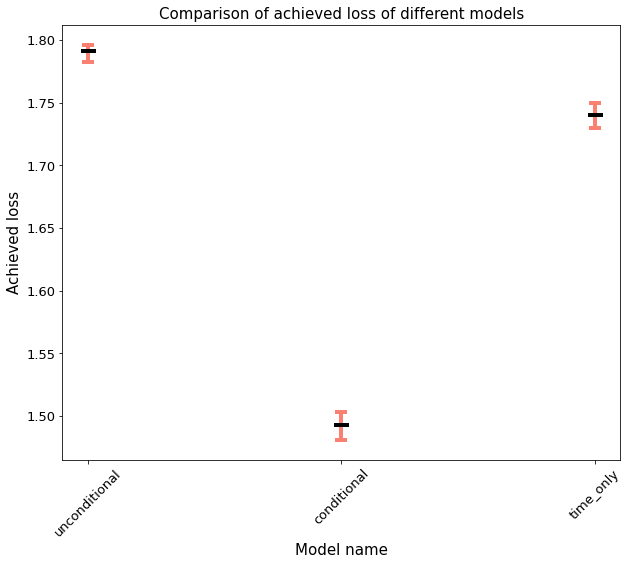

In [25]:
plt.figure(figsize=(10,8))
plt.errorbar(model_names, means, yerr=[lower_err, upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
plt.title("Comparison of achieved loss of different models", fontsize=15)
plt.xticks(model_names, model_names, rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Model name', fontsize=15)
plt.ylabel('Achieved loss', fontsize=15)
plt.show()

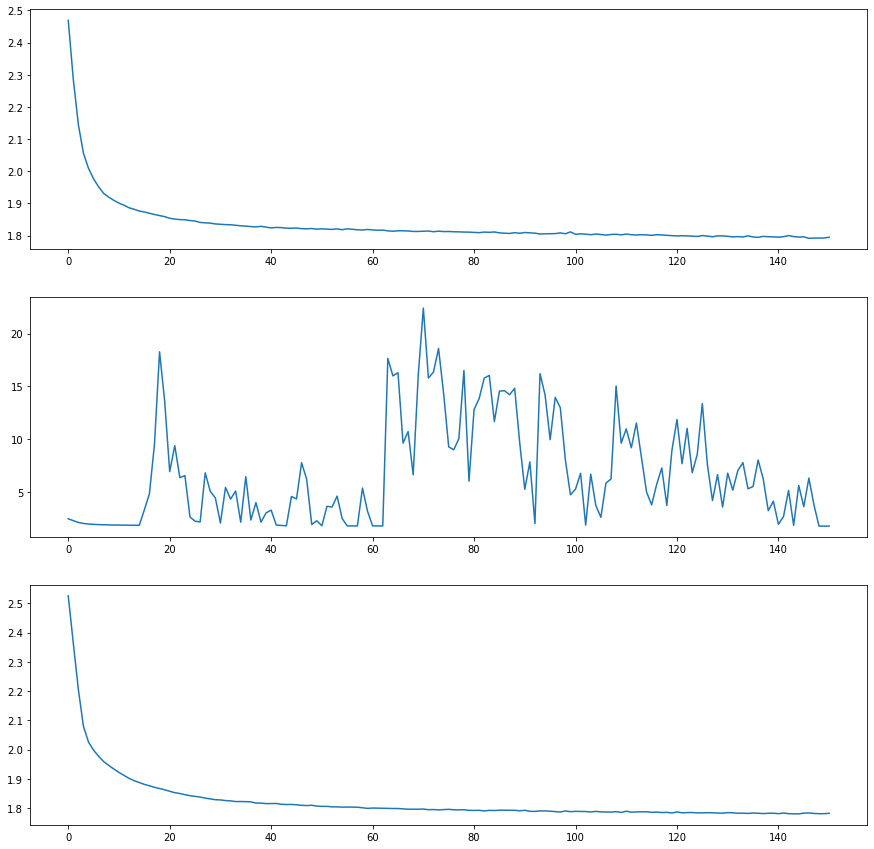

In [26]:
fig, ax = plt.subplots(3, figsize=(15,15))
for i, run in enumerate(runs):
    ax[i].plot(unconditional_dicts[run]['nyc_uncondv2.pickle']['logs']['test'])

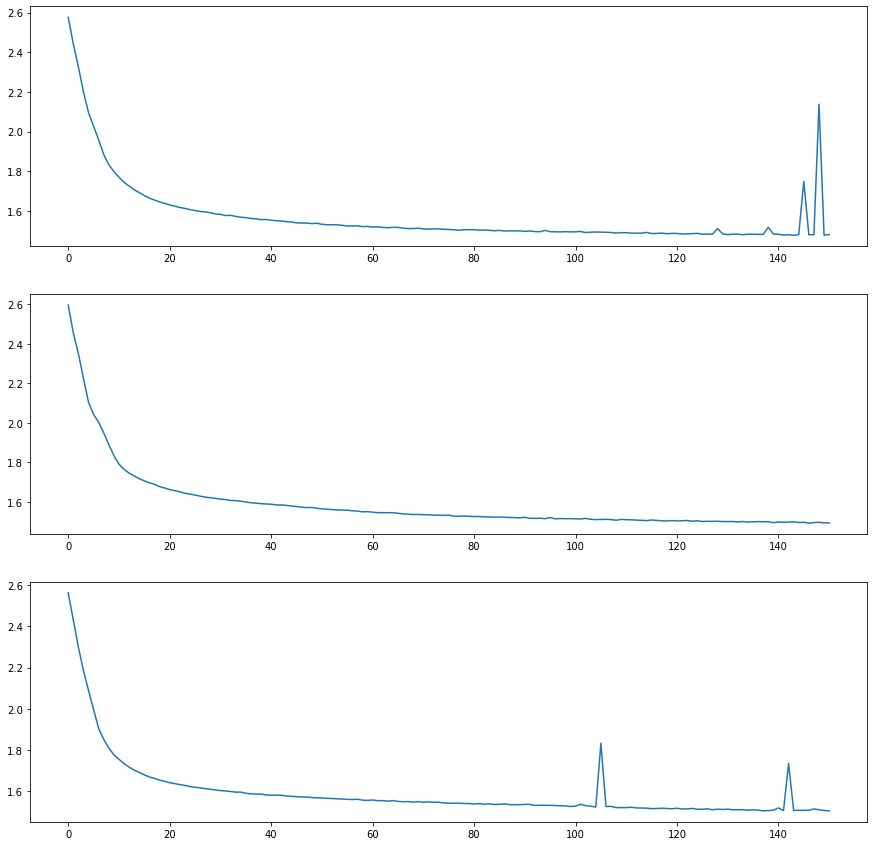

In [27]:

fig, ax = plt.subplots(3, figsize=(15,15))
for i, run in enumerate(runs):
    ax[i].plot(conditional_dicts[run]['nyc_model2.pickle']['logs']['test'])

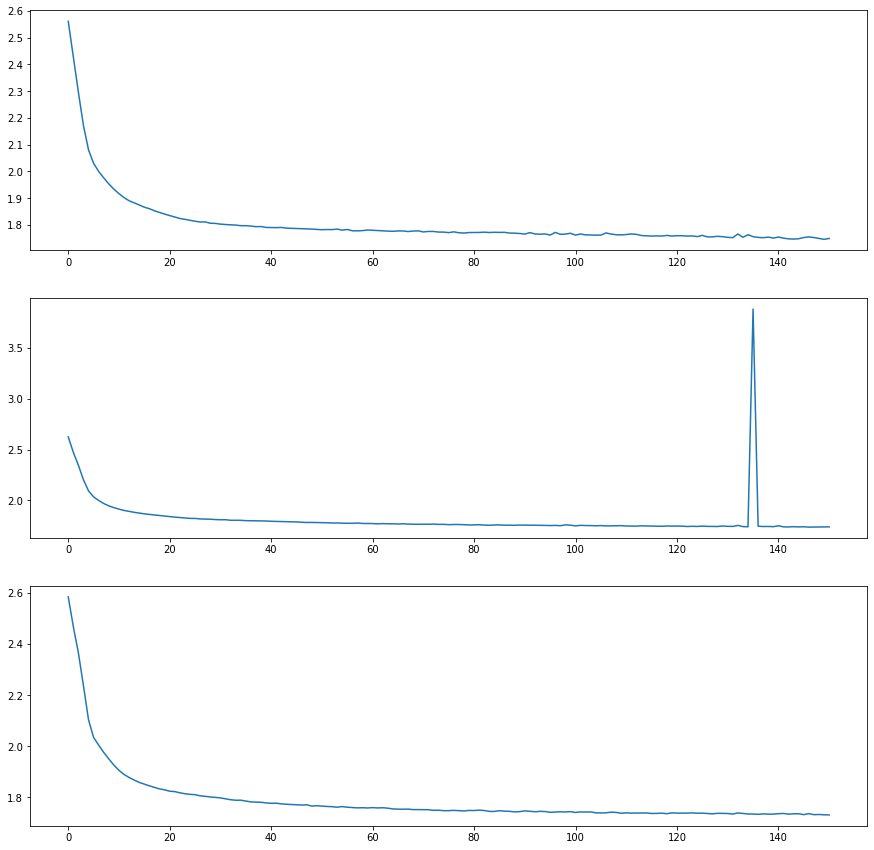

In [28]:
fig, ax = plt.subplots(3, figsize=(15,15))
for i, run in enumerate(runs):
    ax[i].plot(time_only_dicts[run]['nyc_time.pickle']['logs']['test'])

# Model visualization


## Uncond model

In [0]:
uncond_flow1 = unconditional_dicts['run1']['nyc_uncondv2.pickle']['model']
uncond_flow2 = unconditional_dicts['run2']['nyc_uncondv2.pickle']['model']
uncond_flow3 = unconditional_dicts['run3']['nyc_uncondv2.pickle']['model']

In [0]:
nyc_data_small_path = f"{dataset_folder}/NYC_yellow_taxi/processed_nyc_taxi_small.csv"

In [0]:
nyc_data_small = pd.read_csv(nyc_data_small_path)
obs_cols = ['dropoff_longitude', 'dropoff_latitude']
context_cols = ['pickup_longitude', 'pickup_latitude',  'pickup_dow_sin', 'pickup_dow_cos',
                 'pickup_tod_sin', 'pickup_tod_cos']

In [0]:
train_dataloader, test_dataloader, obs_scaler, context_scaler= simple_data_split_conditional(df=nyc_data_small,
                                                                  obs_cols=obs_cols,
                                                                  context_cols=context_cols,
                                                                  batch_size=50000,
                                                                  cuda_exp=True)

In [33]:
unconditional_dicts[run]['nyc_uncondv2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_scheduler': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2}

In [0]:
x_bounds = [-74.04, -73.75]
y_bounds = [40.62, 40.86]

x_loc = np.mean(x_bounds)
y_loc = np.mean(y_bounds)

lower_left = [y_bounds[0], x_bounds[0]]
upper_right = [y_bounds[1], x_bounds[1]]
bounds = [lower_left, upper_right]
initial_location = [y_loc, x_loc]

In [0]:
hub_map = folium.Map(width=900,height=1300,location=initial_location, zoom_start=12)
cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)
create_overlay(shape=(800,800), bounds=bounds, flow_dist=uncond_flow1.dist, hub_map=hub_map, cm=cm, flip=True)
# add log prob at JFC
jfc_coords = [40.645587,-73.787536]
add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow1.dist, hub_map=hub_map, name='JFC')

# add log prob at LaGuardia
lg_coords = [40.774277,-73.874258]
add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow1.dist, hub_map=hub_map, name='LaGuardia')

display(hub_map)

In [0]:
hub_map = folium.Map(width=900,height=1300,location=initial_location, zoom_start=12)
cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)
create_overlay(shape=(800,800), bounds=bounds, flow_dist=uncond_flow2.dist, hub_map=hub_map, cm=cm, flip=True)
# add log prob at JFC
jfc_coords = [40.645587,-73.787536]
add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow2.dist, hub_map=hub_map, name='JFC')

# add log prob at LaGuardia
lg_coords = [40.774277,-73.874258]
add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow2.dist, hub_map=hub_map, name='LaGuardia')

display(hub_map)

In [0]:
hub_map = folium.Map(width=900,height=1300,location=initial_location, zoom_start=12)
cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)
create_overlay(shape=(800,800), bounds=bounds, flow_dist=uncond_flow3.dist, hub_map=hub_map, cm=cm, flip=True)
# add log prob at JFC
jfc_coords = [40.645587,-73.787536]
add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow3.dist, hub_map=hub_map, name='JFC')

# add log prob at LaGuardia
lg_coords = [40.774277,-73.874258]
add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=uncond_flow3.dist, hub_map=hub_map, name='LaGuardia')

display(hub_map)

# Conditional model

In [0]:
cond_flow1 = conditional_dicts['run1']['nyc_model2.pickle']['model']
cond_flow2 = conditional_dicts['run2']['nyc_model2.pickle']['model']
cond_flow3 = conditional_dicts['run3']['nyc_model2.pickle']['model']

In [0]:
def plot_func(hour, dayofweek, pickup_lat, pickup_lon, flow):
    # Made for the context order:
    #['pickup_longitude', 'pickup_latitude', 'pickup_dow_sin', 'pickup_dow_cos', 'pickup_tod_sin, 'pickup_tod_cos']

    flow.modules.eval()

    pickup_tod_cos, pickup_tod_sin = circle_transform(hour,23)
    pickup_dow_cos, pickup_dow_sin = circle_transform(dayofweek,6)

    context = np.array([[pickup_lon, pickup_lat, pickup_dow_sin, pickup_dow_cos, pickup_tod_sin, pickup_tod_cos]])
    print(context)

    scaled_context = torch.tensor(context_scaler.transform(context)).type(torch.FloatTensor).cuda()
    #scaled_context = torch.tensor([-0.4450,  0.1878, -1.2765, -0.8224,  1.4222, -0.8806]).float().cuda()

    cond_dist = flow.condition(scaled_context)

        
    x_bounds = [-74.04, -73.75]
    y_bounds = [40.62, 40.86]

    x_loc = np.mean(x_bounds)
    y_loc = np.mean(y_bounds)

    lower_left = [y_bounds[0], x_bounds[0]]
    upper_right = [y_bounds[1], x_bounds[1]]
    bounds = [lower_left, upper_right]
    initial_location = [y_loc, x_loc]
    hub_map = folium.Map(width=845,height=920,location=initial_location, zoom_start=12, zoom_control=False)


    cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)

    create_overlay(shape=(800,800), bounds=bounds, flow_dist=cond_dist, hub_map=hub_map, cm=cm, flip=True)

    #samples = rescale_samples(cond_dist, obs_scaler, n_samples=1000)
    #plot_samples(samples, hub_map)


    folium.CircleMarker(
    location=[pickup_lat, pickup_lon],
    radius=2,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    opacityb=0.1).add_to(hub_map)

    # add log prob at JFC
    jfc_coords = [40.645587,-73.787536]
    add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='JFC')

    # add log prob at LaGuardia
    lg_coords = [40.774277,-73.874258]
    add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='LaGuardia')


    display(hub_map)
    return hub_map

In [38]:
input_hour = 6
input_dayofweek = 1
input_pickup_lon =-73.89500000000001
input_pickup_lat = 40.739999999999995

hub_map = plot_func(hour=input_hour, dayofweek=input_dayofweek, pickup_lat=input_pickup_lat, pickup_lon=input_pickup_lon, flow=cond_flow2)


[[-7.38950000e+01  4.07400000e+01  8.66025404e-01  5.00000000e-01
   9.97668769e-01 -6.82424134e-02]]


In [40]:
input_hour = 18
input_dayofweek = 1
input_pickup_lon =-73.983313
input_pickup_lat = 40.733348

hub_map = plot_func(hour=input_hour, dayofweek=input_dayofweek, pickup_lat=input_pickup_lat, pickup_lon=input_pickup_lon, flow=cond_flow1)

hub_map.save(f'{plot_folder}/nyc_cond_large_manhattan.html')


[[-73.983313    40.733348     0.8660254    0.5         -0.97908409
    0.20345601]]


In [0]:
input_hour = 18
input_dayofweek = 1
input_pickup_lon =-73.983313
input_pickup_lat = 40.733348

hub_map = plot_func(hour=input_hour, dayofweek=input_dayofweek, pickup_lat=input_pickup_lat, pickup_lon=input_pickup_lon, flow=cond_flow2)



[[-73.983313    40.733348     0.8660254    0.5         -0.97908409
    0.20345601]]


In [0]:
input_hour = 18
input_dayofweek = 1
input_pickup_lon =-73.983313
input_pickup_lat = 40.733348

hub_map = plot_func(hour=input_hour, dayofweek=input_dayofweek, pickup_lat=input_pickup_lat, pickup_lon=input_pickup_lon, flow=cond_flow3)



[[-73.983313    40.733348     0.8660254    0.5         -0.97908409
    0.20345601]]


In [0]:
interactive_plot = interactive(plot_func,
                               hour=(0,23),
                               dayofweek=(0,6),
                               pickup_lat=(y_bounds[0],y_bounds[1], 0.01),
                               pickup_lon=(x_bounds[0],x_bounds[1], 0.01),
                               flow=fixed(cond_flow1)
                               )
hub_map = interactive_plot
display(hub_map)


interactive(children=(IntSlider(value=11, description='hour', max=23), IntSlider(value=3, description='dayofwe…

# Time only model

In [0]:
time_only_flow1 = time_only_dicts['run1']['nyc_time.pickle']['model']
time_only_flow2 = time_only_dicts['run2']['nyc_time.pickle']['model']
time_only_flow3 = time_only_dicts['run3']['nyc_time.pickle']['model']

In [0]:
time_only_dicts['run3']['nyc_time.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 4,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

In [0]:
nyc_data_small = pd.read_csv(nyc_data_small_path)
obs_cols = ['dropoff_longitude', 'dropoff_latitude']
context_cols = ['pickup_dow_sin', 'pickup_dow_cos',
                 'pickup_tod_sin', 'pickup_tod_cos']

In [0]:
train_dataloader, test_dataloader, obs_scaler, context_scaler= simple_data_split_conditional(df=nyc_data_small,
                                                                  obs_cols=obs_cols,
                                                                  context_cols=context_cols,
                                                                  batch_size=50000,
                                                                  cuda_exp=True)

In [0]:
def plot_func_time_only(hour, dayofweek, flow):
    # Made for the context order:
    # ['pickup_dow_sin', 'pickup_dow_cos', 'pickup_tod_sin', 'pickup_tod_cos']

    flow.modules.eval()

    pickup_tod_cos, pickup_tod_sin = circle_transform(hour,23)
    pickup_dow_cos, pickup_dow_sin = circle_transform(dayofweek,6)

    context = np.array([[pickup_dow_sin, pickup_dow_cos, pickup_tod_sin, pickup_tod_cos]])
    print(context)

    scaled_context = torch.tensor(context_scaler.transform(context)).type(torch.FloatTensor).cuda()
    #scaled_context = torch.tensor([-0.4450,  0.1878, -1.2765, -0.8224,  1.4222, -0.8806]).float().cuda()

    cond_dist = flow.condition(scaled_context)

        
    x_bounds = [-74.04, -73.75]
    y_bounds = [40.62, 40.86]

    x_loc = np.mean(x_bounds)
    y_loc = np.mean(y_bounds)

    lower_left = [y_bounds[0], x_bounds[0]]
    upper_right = [y_bounds[1], x_bounds[1]]
    bounds = [lower_left, upper_right]
    initial_location = [y_loc, x_loc]
    hub_map = folium.Map(width=900,height=1300,location=initial_location, zoom_start=12)


    cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)

    create_overlay(shape=(800,800), bounds=bounds, flow_dist=cond_dist, hub_map=hub_map, cm=cm, flip=True)

    #samples = rescale_samples(cond_dist, obs_scaler, n_samples=1000)
    #plot_samples(samples, hub_map)

    # add log prob at JFC
    jfc_coords = [40.645587,-73.787536]
    add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='JFC')

    # add log prob at LaGuardia
    lg_coords = [40.774277,-73.874258]
    add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='LaGuardia')

    display(hub_map)
    return hub_map

In [0]:
input_hour = 6
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow1)



[[ 0.          1.          0.99766877 -0.06824241]]


In [0]:
input_hour = 6
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow2)



[[ 0.          1.          0.99766877 -0.06824241]]


In [0]:
input_hour = 6
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow3)



[[ 0.          1.          0.99766877 -0.06824241]]


In [0]:
input_hour = 24
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow1)



[[0.         1.         0.26979677 0.96291729]]


In [0]:
input_hour = 24
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow2)



[[0.         1.         0.26979677 0.96291729]]


In [0]:
input_hour = 24
input_dayofweek = 0

hub_map = plot_func_time_only(hour=input_hour, dayofweek=input_dayofweek, flow=time_only_flow3)



[[0.         1.         0.26979677 0.96291729]]


# Path stuff 2

In [0]:
def plot_func(hour, dayofweek, pickup_lat, pickup_lon, flow):
    # Made for the context order:
    #['pickup_longitude', 'pickup_latitude', 'pickup_dow_sin', 'pickup_dow_cos', 'pickup_tod_sin, 'pickup_tod_cos']

    flow.modules.eval()

    pickup_tod_cos, pickup_tod_sin = circle_transform(hour,23)
    pickup_dow_cos, pickup_dow_sin = circle_transform(dayofweek,6)

    context = np.array([[pickup_lon, pickup_lat, pickup_dow_sin, pickup_dow_cos, pickup_tod_sin, pickup_tod_cos]])
    print(context)

    scaled_context = torch.tensor(context_scaler.transform(context)).type(torch.FloatTensor).cuda()
    #scaled_context = torch.tensor([-0.4450,  0.1878, -1.2765, -0.8224,  1.4222, -0.8806]).float().cuda()

    cond_dist = flow.condition(scaled_context)

        
    x_bounds = [-73.95, -73.75]
    y_bounds = [40.62, 40.86]

    x_loc = np.mean(x_bounds)
    y_loc = np.mean(y_bounds)

    lower_left = [y_bounds[0], x_bounds[0]]
    upper_right = [y_bounds[1], x_bounds[1]]
    bounds = [lower_left, upper_right]
    #initial_location = [40.739999999999995, -73.85]
    initial_location = [40.720999999999995, -73.855]
    hub_map = folium.Map(width=550,height=650,location=initial_location, zoom_start=12, zoom_control=False)


    cm = sns.cubehelix_palette(reverse=True, dark=0, light=1, gamma=0.8, as_cmap=True)

    create_overlay(shape=(800,800), bounds=bounds, flow_dist=cond_dist, hub_map=hub_map, cm=cm, flip=True)

    #samples = rescale_samples(cond_dist, obs_scaler, n_samples=1000)
    #plot_samples(samples, hub_map)


    folium.CircleMarker(
    location=[pickup_lat, pickup_lon],
    radius=2,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    opacityb=0.1).add_to(hub_map)

    # add log prob at JFC
    jfc_coords = [40.645587,-73.787536]
    add_marker_w_prob(coords=jfc_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='JFC')

    # add log prob at LaGuardia
    lg_coords = [40.774277,-73.874258]
    add_marker_w_prob(coords=lg_coords, obs_scaler=obs_scaler, flow_dist=cond_dist, hub_map=hub_map, name='LaGuardia')

    train_station1 = [40.6586078,-73.8052761]
    folium.CircleMarker(
    location=train_station1,
    radius=2,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    opacityb=0.1).add_to(hub_map)

    train_station2 = [40.6612707,-73.8294946]
    folium.CircleMarker(
    location=train_station2,
    radius=2,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    opacityb=0.1).add_to(hub_map)

    display(hub_map)
    return hub_map

In [43]:
input_hour = 18
input_dayofweek = 1
input_pickup_lon =-73.983313
input_pickup_lat = 40.733348

hub_map = plot_func(hour=input_hour, dayofweek=input_dayofweek, pickup_lat=input_pickup_lat, pickup_lon=input_pickup_lon, flow=cond_flow1)

hub_map.save(f'{plot_folder}/nyc_cond_large_manhattan_path.html')


[[-73.983313    40.733348     0.8660254    0.5         -0.97908409
    0.20345601]]
